# Correlation plots

In [1]:
import pickle
import sys
import matplotlib.pyplot as plt
import numpy as np
from tqdm.auto import tqdm
import os
import pandas as pd
import datetime
import matplotlib.ticker as ticker
sys.path.append("../../")
sys.path.append("../../covid19_inference")
sys.path.append("../")

import covid19_soccer
from covid19_soccer.plot.utils import get_from_trace
import covid19_inference as cov19
from header_plotting import *

In [2]:
%load_ext autoreload
%autoreload 2

In [8]:
countries = ['England', 'Czechia', 'Scotland', 'Spain', 'Italy', 'Slovakia',
       'Germany', 'Austria', 'Belgium', 'France', 'Portugal']
       #'Netherlands']
    
def load(fstr):
    with open(fstr, "rb") as f:
         return pickle.load(f)
        
traces, models, dls = [], [], []
for country in tqdm(countries):
    #'UEFA-beta=False-country=England-offset_games=0-draw_delay=True-weighted_alpha_prior=0-prior_delay=-1-width_delay_prior=0.1-sigma_incubation=-1.0-median_width_delay=1.0-tune=200-draws=300-max_treedepth=10.pickled'
    model = None
    fstr=lambda tune, draws, max_treedepth: (f"/data.nst/smohr/covid19_soccer_data/main_traces/run"+
        f"-beta=False"+
        f"-country={country}"+
        f"-offset_data=0"+
        f"-prior_delay=-1"+
        f"-median_width_delay=1.0"+
        f"-interval_cps=10.0"+
        f"-f_fem=0.33"+
        f"-len=normal"+
        f"-abs_sine=False"+
        f"-t={tune}"+
        f"-d={draws}"+
        f"-max_treedepth={max_treedepth}.pkl")
    #print(fstr(4000, 8000, 12))
    if os.path.exists(fstr(4000, 8000, 12)):
        try:
            model, trace = load(fstr(4000, 8000, 12))
            print(f"Use 8000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(2000, 4000, 12)):
        try:
            model, trace = load(fstr(2000, 4000, 12))
            print(f"Use 4000 sample runs for {country}")
        except:
            pass
    if model is None and os.path.exists(fstr(1000, 1500, 12)):
        try: 
            model, trace = load(fstr(1000, 1500, 12))
            print(f"Use 1500 sample runs for {country}")
        except:
            pass
    if model is None:
        print(" not found")
        continue
    
    # Remove chains with likelihood larger than -200, should only be the case for 2 chains in France
    mask = (np.mean(trace.sample_stats.lp, axis=1)>-200)
    trace.posterior = trace.posterior.sel(chain=~mask)
    
    dl = covid19_soccer.dataloader.Dataloader_gender(countries=[country])
    models.append(model)
    traces.append(trace)
    dls.append(dl)

  0%|          | 0/11 [00:00<?, ?it/s]

Use 4000 sample runs for England
Use 4000 sample runs for Czechia
Use 4000 sample runs for Scotland
Use 4000 sample runs for Spain
Use 4000 sample runs for Italy
Use 4000 sample runs for Slovakia
Use 4000 sample runs for Germany
Use 4000 sample runs for Austria
Use 4000 sample runs for Belgium
Use 4000 sample runs for France
Use 4000 sample runs for Portugal


In [9]:
infections_no = []
infections_primary = []
infections_secondary = []
for i, country in tqdm(enumerate(countries)):
    trace_without_soccer, trace_primary_soccer = load(f"/data.nst/smohr/covid19_soccer_data/primary_and_subsequent/{country}.pkl")
    shape = trace_without_soccer.predictions["new_cases"].to_numpy().shape
    x = pd.date_range(models[i].sim_begin, models[i].sim_end)
    y0 = trace_without_soccer.predictions["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4])
    y1 = trace_primary_soccer.predictions["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]) - y0
    y2 = traces[i].posterior["new_cases"].to_numpy().reshape(shape[0]*shape[1]*shape[2],shape[3],shape[4]) - y1 - y0

    begin = datetime.datetime(2021, 6, 11)
    end = datetime.datetime(2021, 7, 31)
    i_begin = (begin - model.sim_begin).days
    i_end = (end - model.sim_begin).days + 1  # inclusiv last day

    y0 = np.sum(y0[..., i_begin:i_end, :], axis=-2)
    y1 = np.sum(y1[..., i_begin:i_end, :], axis=-2)
    y2 = np.sum(y2[..., i_begin:i_end, :], axis=-2)

    infections_no.append(y0)
    infections_primary.append(y1)
    infections_secondary.append(y2)

0it [00:00, ?it/s]

In [10]:
data_primary  = pd.DataFrame()
means = []
for i,country in enumerate(countries):
    # compute fraction of infected people
    t_numpy = infections_primary[i] / (infections_no[i] + infections_primary[i] + infections_secondary[i]) * 100

    male = np.stack(
        (t_numpy[:, 0], np.zeros(t_numpy[:, 0].shape)), axis=1
    )
    female = np.stack(
        (t_numpy[:, 1], np.ones(t_numpy[:, 1].shape)), axis=1
    )
    # Create dataframe for plotting
    temp = pd.DataFrame(np.concatenate((male, female)), columns=["percentage_primary", "gender"])
    temp["gender"] = pd.cut(
        temp["gender"], bins=[-1, 0.5, 1], labels=["male", "female"]
    )
    temp["country"] = country
    data_primary = pd.concat([data_primary, temp])
    means.append(np.mean(temp["percentage_primary"]))
country_order_primar = np.argsort(means)[::-1]

data_primary_and_subsequent = pd.DataFrame()
means = []
for i, country in enumerate(countries):

    # compute fraction
    t_numpy = (infections_primary[i]+infections_secondary[i])/(infections_no[i] + infections_primary[i] + infections_secondary[i]) * 100

    male = np.stack(
        (t_numpy[:, 0], np.zeros(t_numpy[:, 0].shape)), axis=1
    )
    female = np.stack(
        (t_numpy[:, 1], np.ones(t_numpy[:, 1].shape)), axis=1
    )
    # Create dataframe for plotting
    temp = pd.DataFrame(np.concatenate((male, female)), columns=["percentage_primary_and_subsequent", "gender"])
    temp["gender"] = pd.cut(
        temp["gender"], bins=[-1, 0.5, 1], labels=["male", "female"]
    )
    temp["country"] = country
    data_primary_and_subsequent = pd.concat([data_primary_and_subsequent, temp])
    means.append(np.mean(temp["percentage_primary_and_subsequent"]))
country_order_primary_and_subsequent = np.argsort(means)[::-1]

## Correlation between NPIs stringency pre EURO2020 and effect size
Get data for the non-pharmacutical interventions (NPIs) stringency as tracked by the Oxford Stringency Index and by the PHMS stringency index.

In [11]:
# Compute interesting values as fraction and as incidence
primary_frac = []
for i, country in enumerate(countries):
    temp = data_primary[data_primary["country"] == country].drop(columns=["country"])
    primary_frac.append(np.mean(temp.to_numpy()[:,0].reshape((2,-1)), axis=0))


primary_and_subsequent_frac = []
for i, country in enumerate(countries):
    temp = data_primary_and_subsequent[data_primary_and_subsequent["country"] == country].drop(columns=["country","gender"])
    primary_and_subsequent_frac.append(temp.to_numpy()[:,0])


primary_inci = []
for i, country in enumerate(countries):
    temp = infections_primary[i]
    primary_inci.append(temp.sum(axis=1) / dls[i].population.sum()*1e6)

primary_and_subsequent_inci = []
for i, country in enumerate(countries):
    temp = infections_primary[i] + infections_secondary[i]
    primary_and_subsequent_inci.append(temp.sum(axis=1) / dls[i].population.sum()*1e6)
    


In [50]:
# Load stringency index
from covid19_inference import data_retrieval as cov19dat

stringency = cov19dat.OxCGRT()
stringency.url_csv = 'https://raw.githubusercontent.com/OxCGRT/covid-policy-tracker-legacy/main/legacy_data_202207/OxCGRT_latest.csv'
stringency.download_all_available_data(force_download=True)

INFO     [covid19_inference.data_retrieval.retrieval] Successfully downloaded OxCGRT.csv.gz to /tmp/covid19_data/.
INFO     [covid19_inference.data_retrieval.retrieval] Local backup to /tmp/covid19_data/OxCGRT.csv.gz successful.


In [54]:
import datetime
columnsStringencyPreEuro2020 = []
stdStringencyPreEuro2020 = []

# Begin and end dates for EURO2020
begin = datetime.datetime(2021, 6, 11)
end = datetime.datetime(2021, 7, 11)

for i, country in enumerate(countries):
    if country == "Slovakia":
        country = "Slovak Republic"
    if country == "Czechia":
        country = "Czech Republic"
    if country in ["England","Scotland"]:
        SindexCountry = stringency.data[stringency.data["RegionName"] == country]["StringencyIndex"][begin-datetime.timedelta(days=14):begin]
    else:
        SindexCountry = stringency.data[stringency.data["country"] == country]["StringencyIndex"][begin-datetime.timedelta(days=14):begin]

    meanStringencyPreEuro2020.append(SindexCountry.mean())
    stdStringencyPreEuro2020.append(SindexCountry.std())

In [14]:
meanStringencyPHMSPreEuro2020 = []
stdStringencyPHMSPreEuro2020 = []

# Load data
phms = pd.read_csv("../../data/Severity index - 2022-03-31.csv")
phms["Date"] = pd.to_datetime(phms["Date"],format="%d-%b-%y")
phms = phms.set_index(["Country","Date"])
# Begin and end dates for EURO2020
begin = datetime.datetime(2021, 6, 11)
end = datetime.datetime(2021, 7, 11)

for i, country in enumerate(countries):
    if country == "Czechia":
        country = "Czech Republic"
    if country in ["England","Scotland"]:
        country = "United Kingdom"
        
    SindexCountry = phms.loc[country,:]["PHSM SI"].resample('D').fillna(0)[begin-datetime.timedelta(days=14):begin]
    
    meanStringencyPHMSPreEuro2020.append(SindexCountry.mean())
    stdStringencyPHMSPreEuro2020.append(SindexCountry.std())

## Correlation between Mobility during EURO2020 and effect size

Creates a correlation plot between google mobility index and the primary and secondary soccer related effect.

In [15]:
mobility = cov19dat.GOOGLE(True)
df = mobility.data
df = df.reset_index()

INFO     [covid19_inference.data_retrieval.retrieval] Successfully downloaded Google.csv.gz to /tmp/covid19_data/.
INFO     [covid19_inference.data_retrieval.retrieval] Local backup to /tmp/covid19_data/Google.csv.gz successful.


In [16]:
city2country = {
    'Aberdeen City': 'Scotland',
    'Aberdeenshire': 'Scotland',
    'Angus Council': 'Scotland',
    'Antrim and Newtownabbey': 'Northern Ireland',
    'Ards and North Down': 'Northern Ireland',
    'Argyll and Bute Council': 'Scotland',
    'Armagh City, Banbridge and Craigavon': 'Northern Ireland',
    'Bath and North East Somerset': 'England',
    'Bedford': 'England',
    'Belfast': 'Northern Ireland',
    'Blackburn with Darwen': 'England',
    'Blackpool': 'England',
    'Blaenau Gwent': 'Wales',
    'Borough of Halton': 'England',
    'Bracknell Forest': 'England',
    'Bridgend County Borough': 'Wales',
    'Brighton and Hove': 'England',
    'Bristol City': 'England',
    'Buckinghamshire': 'England', 
    'Caerphilly County Borough': 'Wales',
    'Cambridgeshire': 'England', 
    'Cardiff': 'Wales',
    'Carmarthenshire': 'Wales', 
    'Causeway Coast and Glens': 'England',
    'Central Bedfordshire': 'England',
    'Ceredigion': 'Wales',
    'Cheshire East': 'England',
    'Cheshire West and Chester': 'England',
    'Clackmannanshire': 'Scotland',
    'Conwy Principal Area': 'Wales',
    'Cornwall': 'England',
    'County Durham': 'England',
    'Cumbria': 'England',
    'Darlington': 'England',
    'Denbighshire': 'Wales',
    'Derby': 'England',
    'Derbyshire': 'England',
    'Derry and Strabane': 'Northern Ireland',
    'Devon': 'England',
    'Dorset': 'England',
    'Dumfries and Galloway': 'Scotland',
    'Dundee City Council': 'Scotland',
    'East Ayrshire Council': 'Scotland',
    'East Dunbartonshire Council': 'Scotland',
    'East Lothian Council': 'Scotland',
    'East Renfrewshire Council': 'Scotland',
    'East Riding of Yorkshire': 'England',
    'East Sussex': 'England',
    'Edinburgh': 'Scotland',
    'Essex': 'England',
    'Falkirk': 'Scotland',
    'Fermanagh and Omagh': 'Northern Ireland',
    'Fife': 'Scotland',
    'Flintshire': 'Wales',
    'Glasgow City': 'Scotland',
    'Gloucestershire': 'England',
    'Greater London': 'England',
    'Greater Manchester': 'England',
    'Gwynedd': 'Wales',
    'Hampshire': 'England',
    'Hartlepool': 'England',
    'Herefordshire': 'England',
    'Hertfordshire': 'England',
    'Highland Council': 'Scotland',
    'Inverclyde': 'Scotland',
    'Isle of Anglesey': 'Wales',
    'Isle of Wight': 'England',
    'Kent': 'England',
    'Kingston upon Hull': 'England',
    'Lancashire': 'England',
    'Leicester': 'England',
    'Leicestershire': 'England',
    'Lincolnshire': 'England',
    'Lisburn and Castlereagh': 'Northern Ireland',
    'Luton': 'England',
    'Medway': 'England',
    'Merseyside': 'England',
    'Merthyr Tydfil County Borough': 'Wales',
    'Mid and East Antrim': 'Northern Ireland',
    'Mid Ulster': 'Northern Ireland',
    'Middlesbrough': 'England',
    'Midlothian': 'Scotland',
    'Milton Keynes':  'England',
    'Monmouthshire': 'Wales',
    'Moray': 'Scotland',
    'Na h-Eileanan an Iar': 'Scotland',
    'Neath Port Talbot Principle Area': 'Wales',
    'Newport': 'Wales',
    'Newry, Mourne and Down': 'Northern Ireland',
    'Norfolk': 'England',
    'North Ayrshire Council': 'Scotland',
    'North East Lincolnshire': 'England',
    'North Lanarkshire': 'Scotland',
    'North Lincolnshire': 'England',
    'North Somerset': 'England',
    'North Yorkshire': 'England',
    'Northamptonshire': 'England',
    'Northumberland': 'England',
    'Nottingham': 'England',
    'Nottinghamshire': 'England',
    'Orkney': 'Scotland',
    'Oxfordshire': 'England',
    'Pembrokeshire': 'Wales',   
    'Perth and Kinross': 'Scotland',
    'Peterborough': 'England',
    'Plymouth': 'England',
    'Portsmouth': 'England',
    'Powys': 'Wales',
    'Reading': 'England',
    'Redcar and Cleveland': 'England',
    'Renfrewshire': 'Scotland',
    'Rhondda Cynon Taff': 'Wales',
    'Rutland': 'England',
    'Scottish Borders': 'Scotland',
    'Shetland Islands': 'Scotland',
    'Shropshire': 'England',
    'Slough': 'England',
    'Somerset': 'England',
    'South Ayrshire Council': 'Scotland',
    'South Gloucestershire': 'England',
    'South Lanarkshire': 'Scotland',
    'South Yorkshire': 'England',
    'Southampton': 'England',
    'Southend-on-Sea': 'England',
    'Staffordshire': 'England',
    'Stirling': 'Scotland',
    'Stockton-on-Tees': 'England',
    'Stoke-on-Trent': 'England',
    'Suffolk': 'England',
    'Surrey': 'England',
    'Swansea': 'Wales',
    'Swindon': 'England',
    'Thurrock': 'England',
    'Torbay': 'England',
    'Torfaen Principal Area': 'Wales',
    'Tyne and Wear': 'England',
    'Vale of Glamorgan': 'Wales',
    'Warrington': 'England',
    'Warwickshire': 'England',
    'West Berkshire': 'England',
    'West Dunbartonshire Council': 'Scotland',
    'West Lothian': 'Scotland',
    'West Midlands': 'England',
    'West Sussex': 'England',
    'West Yorkshire': 'England',
    'Wiltshire': 'England',
    'Windsor and Maidenhead': 'England',
    'Wokingham': 'England',
    'Worcestershire': 'England',
    'Wrexham Principal Area': 'Wales',
    'York': 'England'
}


def apply_city_to_country(row):
    if row["state"] in city2country:
        row["country"] = city2country[row["state"]]
    return row

df[df["country"]=="United Kingdom"] = df[df["country"]=="United Kingdom"].apply(apply_city_to_country, axis=1)

In [17]:
measures = ['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline']

measure2title = {
    'retail_and_recreation_percent_change_from_baseline': 'Retail and recreation',
    'grocery_and_pharmacy_percent_change_from_baseline': 'Grocery and pharmacy',
    'parks_percent_change_from_baseline': 'Parks',
    'transit_stations_percent_change_from_baseline': 'Transit stations',
    'workplaces_percent_change_from_baseline': 'Workplaces',
    'residential_percent_change_from_baseline': 'Residential'
}

meanMobilityEuro2020 = {}
for measure in measures:
    meanMobilityEuro2020[measure] = []

for i, country in enumerate(countries):
    # Mean over all Scotland and England entries
    if country in ["Scotland","England"]:
        temp = df[df["country"]==country].groupby("date").mean()
    else:
        temp = df[df["country"]==country]
    
    if "state" in temp.columns:
        temp = temp[temp["state"].isna()]

    temp = temp.groupby("date").mean()

    for i, measure in enumerate(measures):
        meanMobilityEuro2020[measure].append(temp[measure][begin:end].to_numpy())


## Correlation between Reproduction number pre EURO2020 and effect size

Correlation plot reproduction number pre EURO2020 as inferred from our model and effect size.

In [18]:
reproNumberPreEURO2020 = []
reproNumberPostEuro2020 = []
for i, country in enumerate(countries):
    i_begin = (begin - models[i].sim_begin).days
    R = traces[i].posterior["R_t_base"][:,:,i_begin-14:i_begin].to_numpy()
    R = R.reshape(R.shape[0]*R.shape[1]*R.shape[2])
    reproNumberPreEURO2020.append(R)

    i_end = (end - models[i].sim_begin).days
    R = traces[i].posterior["R_t_base"][:,:,i_end-14:i_end].to_numpy()
    R = R.reshape(R.shape[0]*R.shape[1]*R.shape[2])
    reproNumberPostEuro2020.append(R)


## Correlation between incidence pre EURO2020 and effect size

In [20]:
from covid19_inference import data_retrieval as cov19dat

jhu = cov19dat.JHU(True)


incedencePreEuro2020 = []
incedencePreEuro2020STD = []
incedencePreEuro2020SUM = []
for i, country in enumerate(countries):
    temp = pd.DataFrame()
    temp_m = dls[i]._cases.loc[
        begin - datetime.timedelta(days=21) : begin,
        "male",
        "total",
    ]
    temp_f = dls[i]._cases.loc[
        begin - datetime.timedelta(days=21) : begin,
        "female",
        "total",
    ]

    # Reshape to date, gender and male at the front
    t =  np.stack((temp_m.to_numpy(), temp_f.to_numpy()), axis=1)
    incidence = t.sum(axis=(1,2)) / dls[i].population.sum()*1e6
    incedencePreEuro2020SUM.append(t.sum(axis=(0,1,2)) / dls[i].population.sum()*1e6)
    incedencePreEuro2020.append(incidence.mean())
    incedencePreEuro2020STD.append(incidence.std())
    

INFO     [covid19_inference.data_retrieval._JHU] Successfully downloaded new files.
INFO     [covid19_inference.data_retrieval._JHU] Local backup to ['/tmp/covid19_data/Jhu_confirmed.csv.gz', '/tmp/covid19_data/Jhu_deaths.csv.gz', '/tmp/covid19_data/Jhu_recovered.csv.gz'] successful.


In [21]:
incidenceRelatedToEuro2020 = []
for i, country in enumerate(countries):
    temp = infections_primary[i]+infections_secondary[i]
    incidenceRelatedToEuro2020.append(temp.sum(axis=1) / dls[i].population.sum()*1e6)

## Data num Games played

In [22]:
import pymc3 as pm
table_3 = []

df = pd.read_csv("../../data/em_game_data.csv",header=2)
df = df[~df["id"].astype("str").str.contains("a")] # Filter extra games we added for validation these are suffixed with a
df[" date"]= pd.to_datetime(df[" date"])

country2location = {
    "GB-ENG":"London",
    "IT":"Rome",
    "AZ":"Baku",
    "DE":"Munich",
    "RU":"Saint Petersburg",
    "HU":"Budapest",
    "ES":"Seville",
    "RO":"Bucharest",
    "NL":"Amsterdam",
    "GB-SCT":"Glasgow",
    "DK":"Copenhagen"
}
country_order_primar = list(range(len(countries)))
for i, country in enumerate(np.array(countries)):
    c = country_order_primar[i]
    iso2 = dls[c].countries_iso2[0]
    gamesByTeam = df[df[' team1'].str.contains(iso2) | df[' team2'].str.contains(iso2)] 


    
    if iso2 in country2location:
        location = country2location[iso2]
        gamesHosted = df[df[' location'].str.contains(location)]
    else:
        location = "placeholder"
        gamesHosted = np.zeros((0,8))
    
    union = df[df[' team1'].str.contains(iso2) | df[' team2'].str.contains(iso2) |  df[' location'].str.contains(location)]
    row = []
    row.append(country)
    row.append(gamesByTeam.shape[0])
    row.append(gamesHosted.shape[0])
    row.append(union.shape[0])
    row.append((gamesByTeam[" date"].max()-gamesByTeam[" date"].min()).days)
    
    
    table_3.append(row)
nGamesUnion=np.array(table_3)[:,3].astype(int)
nGamesPlayed = np.array(table_3)[:,1].astype(int)
daysInTournament = np.array(table_3)[:,4].astype(int)

## Pairwise correlation with pymc3

This runs the analysis, can take quite a while as it is not parallised. You can also load the traces from the data repo!
See below.

In [55]:

Y = []
Y_err = []
Y_frac = []
Y_frac_err = []
X = []
X_err = []

for i, country in enumerate(countries):
    X_c = []
    X_err_c = []


    Y.append(primary_and_subsequent_inci[i].mean())
    Y_err.append(primary_and_subsequent_inci[i].std())
    
    Y_frac.append(primary_frac[i].mean())
    Y_frac_err.append(primary_frac[i].std())

    x1 = reproNumberPreEURO2020[i].mean()
    x1_err = reproNumberPreEURO2020[i].std()
    X_c.append(x1)
    X_err_c.append(x1_err)

    x2 = incedencePreEuro2020SUM[i]
    x2_err = incedencePreEuro2020STD[i]
    X_c.append(x2)
    X_err_c.append(x2_err)

    x3 = meanStringencyPreEuro2020[i]
    x3_err = stdStringencyPreEuro2020[i]
    X_c.append(x3)
    X_err_c.append(x3_err)
    
    # Get mobility
    for measure in measures:
        X_c.append(meanMobilityEuro2020[measure][i].mean())
        X_err_c.append(meanMobilityEuro2020[measure][i].std()/np.sqrt(len(meanMobilityEuro2020[measure][i])))

    X.append(X_c)
    X_err.append(X_err_c)

    #print(Y[i]-Y_err[i], Y[i]+Y_err[i])
    #print(np.percentile(primary_and_subsequent_inci[i],[2.5,97.5]))

# Has now shape country, categorie
X = np.array(X)
X_err = np.array(X_err)

# Has now shape country
Y = np.array(Y)
Y_err = np.array(Y_err)

n_countries = X.shape[0]

In [31]:
def reduce_samples(curr_list):
    number_of_samples = 500
    for i, array in enumerate(curr_list):
        array = array[...,np.random.choice(array.shape[-1], number_of_samples, replace = False)]
        curr_list[i] = array
    return np.array(curr_list).astype('float')

primary_frac_redu = reduce_samples(primary_frac)
primary_and_subsequent_inci_redu = reduce_samples(primary_and_subsequent_inci)

def get_model(X,X_err,Y=Y,pBeta=100_000):
    with pm.Model() as model:
        # Priors Y
        y_data = pm.Data("Y", Y) #

        # Prior X
        x_data = pm.Data("X",X)
        x_data_err = pm.Data("X_err",X_err)
        error = pm.Normal("error", mu=0, sd=1, shape=(n_countries))*x_data_err # Xerror

        # Prior linear fit i.e. no effect 
        tau = pm.HalfCauchy("tau", beta=10_000)
        beta = pm.Normal('beta', mu=0, sd=pBeta)
        intercept = pm.Normal('intercept', mu=0, sd=10_000)

        # Country shape
        mu = intercept+(x_data+error)*beta

        deviation = pm.Normal("deviation", mu=0, sigma=1, shape=(n_countries))
        country_effect = deviation*tau + mu
        country_effect = pm.Deterministic("country_effect", country_effect)

        sigma_obs = pm.HalfCauchy("sigma", beta=10000, shape=(n_countries))

        pm.StudentT("y_obs", nu=4, mu=country_effect[...,None], sigma=sigma_obs[...,None], observed=y_data)
    return model


In [56]:
modelStringencyPreEURO2020 = get_model(X[:,2],X_err[:,2],Y=primary_and_subsequent_inci_redu)
traceStringencyPreEURO2020 = pm.sample(2000, tune=2000, cores=4, target_accept=0.9,return_inferencedata=True,model=modelStringencyPreEURO2020)

with open(f"/data.nst/smohr/covid19_soccer_data/correlations/stringencyPre2020.pkl", "wb") as f:
    pickle.dump((modelStringencyPreEURO2020,traceStringencyPreEURO2020), f)


Auto-assigning NUTS sampler...
INFO     [pymc3] Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO     [pymc3] Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
INFO     [pymc3] Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, deviation, intercept, beta, tau, error]
INFO     [pymc3] NUTS: [sigma, deviation, intercept, beta, tau, error]


Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1247 seconds.
INFO     [pymc3] Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 1247 seconds.
The acceptance probability does not match the target. It is 0.8358086678068615, but should be close to 0.9. Try to increase the number of tuning steps.
WARNING  [pymc3] The acceptance probability does not match the target. It is 0.8358086678068615, but should be close to 0.9. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
WARNING  [pymc3] The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 726 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR    [pymc3] There were 726 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability doe

Run all models (see below to just load the fisished traces)

In [ ]:
modelStringencyPreEURO2020 = get_model(X[:,2],X_err[:,2],Y=primary_and_subsequent_inci_redu)
traceStringencyPreEURO2020 = pm.sample(2000, tune=2000, cores=4, target_accept=0.9,return_inferencedata=True,model=modelStringencyPreEURO2020)

with open(f"/data.nst/smohr/covid19_soccer_data/correlations/stringencyPre2020.pkl", "wb") as f:
    pickle.dump((modelStringencyPreEURO2020,traceStringencyPreEURO2020), f)


modelReproPreEURO2020 = get_model(X[:,0],X_err[:,0],Y=primary_and_subsequent_inci_redu)
traceReproPreEURO2020 = pm.sample(2000, tune=2000, cores=4, target_accept=0.9,return_inferencedata=True,model=modelReproPreEURO2020)

with open(f"/data.nst/smohr/covid19_soccer_data/correlations/reproPreEURO2020.pkl", "wb") as f:
    pickle.dump((modelReproPreEURO2020,traceReproPreEURO2020), f)


modelIncidencePreEURO2020 = get_model(X[:,1],np.zeros(len(countries)),Y=primary_and_subsequent_inci_redu)
traceIncidencePreEURO2020 = pm.sample(2000, tune=2000, cores=4, target_accept=0.9,return_inferencedata=True,model=modelIncidencePreEURO2020)

with open(f"/data.nst/smohr/covid19_soccer_data/correlations/incidencePreEURO2020.pkl", "wb") as f:
    pickle.dump((modelIncidencePreEURO2020,traceIncidencePreEURO2020), f)


modelNGames = get_model(nGamesUnion, np.zeros(len(countries)),Y=primary_frac_redu)
traceNGames = pm.sample(2000, tune=2000, cores=4, target_accept=0.9,return_inferencedata=True,model=modelNGames)

with open(f"/data.nst/smohr/covid19_soccer_data/correlations/nGamesUnion.pkl", "wb") as f:
    pickle.dump((modelNGames,traceNGames), f)

    
modelNGamesInci = get_model(nGamesUnion, np.zeros(len(countries)),Y=primary_and_subsequent_inci)
traceNGamesInci = pm.sample(2000, tune=2000, cores=4, target_accept=0.9,return_inferencedata=True,model=modelNGamesInci)

with open(f"/data.nst/smohr/covid19_soccer_data/correlations/nGamesUnionInci.pkl", "wb") as f:
    pickle.dump((modelNGamesInci,traceNGamesInci), f)

In [ ]:
measures = ['retail_and_recreation_percent_change_fromgridspeceline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline']

modelMobilityRetail = get_model(X[:,3],X_err[:,3],Y=primary_frac_redu) #Retail and recreation
traceMobilityRetail = pm.sample(2000, tune=2000, cores=4, target_accept=0.9,return_inferencedata=True,model=modelMobilityRetail)
with open(f"/data.nst/smohr/covid19_soccer_data/correlations/mobilityRetail.pkl", "wb") as f:
    pickle.dump((modelMobilityRetail,traceMobilityRetail), f)

modelMobilityGrocery = get_model(X[:,4],X_err[:,4],Y=primary_frac_redu) #Grocery Pharm
traceMobilityGrocery = pm.sample(2000, tune=2000, cores=4, target_accept=0.9,return_inferencedata=True,model=modelMobilityGrocery)
with open(f"/data.nst/smohr/covid19_soccer_data/correlations/mobilityGrocery.pkl", "wb") as f:
    pickle.dump((modelMobilityGrocery,traceMobilityGrocery), f)

modelMobilityParks = get_model(X[:,5],X_err[:,5],Y=primary_frac_redu) #Parks
traceMobilityParks = pm.sample(2000, tune=2000, cores=4, target_accept=0.9,return_inferencedata=True,model=modelMobilityParks)
with open(f"/data.nst/smohr/covid19_soccer_data/correlations/mobilityParks.pkl", "wb") as f:
    pickle.dump((modelMobilityParks,traceMobilityParks), f)

    
modelMobilityTransit = get_model(X[:,6],X_err[:,6],Y=primary_frac_redu) #transit
traceMobilityTransit = pm.sample(2000, tune=2000, cores=4, target_accept=0.9,return_inferencedata=True,model=modelMobilityTransit)
with open(f"/data.nst/smohr/covid19_soccer_data/correlations/mobilityTransit.pkl", "wb") as f:
    pickle.dump((modelMobilityTransit,traceMobilityTransit), f)

modelMobilityWorkplace = get_model(X[:,7],X_err[:,7],Y=primary_frac_redu) #workplaces
traceMobilityWorkplace = pm.sample(2000, tune=2000, cores=4, target_accept=0.9,return_inferencedata=True,model=modelMobilityWorkplace)
    pickle.dump((modelMobilityWorkplace,traceMobilityWorkplace), f)

modelMobilityResidential = get_model(X[:,8],X_err[:,8],Y=primary_frac_redu) #Residential
traceMobilityResidential = pm.sample(2000, tune=2000, cores=4, target_accept=0.9,return_inferencedata=True,model=modelMobilityResidential)
with open(f"/data.nst/smohr/covid19_soccer_data/correlations/mobilityResidential.pkl", "wb") as f:
    pickle.dump((modelMobilityResidential,traceMobilityResidential), f)


modelMobilityWorkplace = get_model(X[:,7],X_err[:,7],Y=primary_frac_redu) #workplaces
traceMobilityWorkplace = pm.sample(2000, tune=2000, cores=4, target_accept=0.9,return_inferencedata=True,model=modelMobilityWorkplace)
with open(f"/data.nst/smohr/covid19_soccer_data/correlations/mobilityWorkplace.pkl", "wb") as f:
    pickle.dump((modelMobilityWorkplace,traceMobilityWorkplace), f)

In [ ]:
X_combined = []
X_combined_err = []
for i, country in enumerate(countries):
    X_c = []
    X_err_c = []
    
    X_c.append(incedencePreEuro2020SUM[i] * reproNumberPreEURO2020[i].mean()**10 * nGamesPlayed[i])
    X_err_c.append(0)
    
    
    X_c.append(incedencePreEuro2020SUM[i] * reproNumberPreEURO2020[i].mean() ** (daysInTournament[i]/4))
    X_err_c.append(0)
    

    X_combined.append(X_c)
    X_combined_err.append(X_err_c)

X_combined = np.array(X_combined)
X_combined_err = np.array(X_combined_err)

modelCombined0 = get_model(X_combined[:,0],X_combined_err[:,0],Y=primary_and_subsequent_inci_redu) 
modelCombined1 = get_model(X_combined[:,1],X_combined_err[:,1],Y=primary_and_subsequent_inci_redu)

#traceCombined0 = pm.sample(2000, tune=2000, cores=4, target_accept=0.9,return_inferencedata=True,model=modelCombined0)
traceCombined1 = pm.sample(8000, tune=2000, cores=4, target_accept=0.9,return_inferencedata=True,model=modelCombined1)

with open(f"/data.nst/smohr/covid19_soccer_data/correlations/potential.pkl", "wb") as f:
    pickle.dump((modelCombined1,traceCombined1), f)

In [ ]:
modelMobilityParksInci = get_model(X[:,5],X_err[:,5],Y=primary_and_subsequent_inci_redu) #Parks
modelMobilityParksInci = pm.sample(2000, tune=2000, cores=4, target_accept=0.9,return_inferencedata=True,model=modelMobilityParksInci)
with open(f"/data.nst/smohr/covid19_soccer_data/correlations/mobilityParksInci.pkl", "wb") as f:
    pickle.dump((modelMobilityParksInci,modelMobilityParksInci), f)


### Load in case the analysis should not be rerun

In [36]:
modelStringencyPreEURO2020,traceStringencyPreEURO2020 = load(f"/data.nst/smohr/covid19_soccer_data/correlations/stringencyPre2020.pkl")
modelReproPreEURO2020,traceReproPreEURO2020 = load("/data.nst/smohr/covid19_soccer_data/correlations/reproPreEURO2020.pkl")
modelIncidencePreEURO2020,traceIncidencePreEURO2020 = load(f"/data.nst/smohr/covid19_soccer_data/correlations/incidencePreEURO2020.pkl")
modelNGames,traceNGames = load("/data.nst/smohr/covid19_soccer_data/correlations/nGamesUnion.pkl")
modelNGamesInci, traceNGamesInci = load("/data.nst/smohr/covid19_soccer_data/correlations/nGamesUnionInci.pkl")

modelMobilityRetail,traceMobilityRetail = load("/data.nst/smohr/covid19_soccer_data/correlations/mobilityRetail.pkl")
modelMobilityGrocery,traceMobilityGrocery = load("/data.nst/smohr/covid19_soccer_data/correlations/mobilityGrocery.pkl")
modelMobilityParks,traceMobilityParks = load("/data.nst/smohr/covid19_soccer_data/correlations/mobilityParks.pkl")
modelMobilityTransit,traceMobilityTransit = load("/data.nst/smohr/covid19_soccer_data/correlations/mobilityTransit.pkl")
modelMobilityWorkplace,traceMobilityWorkplace = load("/data.nst/smohr/covid19_soccer_data/correlations/mobilityWorkplace.pkl")
modelMobilityResidential,traceMobilityResidential = load("/data.nst/smohr/covid19_soccer_data/correlations/mobilityResidential.pkl")

modelCombined1,traceCombined1 = load("/data.nst/smohr/covid19_soccer_data/correlations/potential.pkl")
modelMobilityParksInci, traceMobilityParksInci = load("/data.nst/smohr/covid19_soccer_data/correlations/mobilityParksInci.pkl")

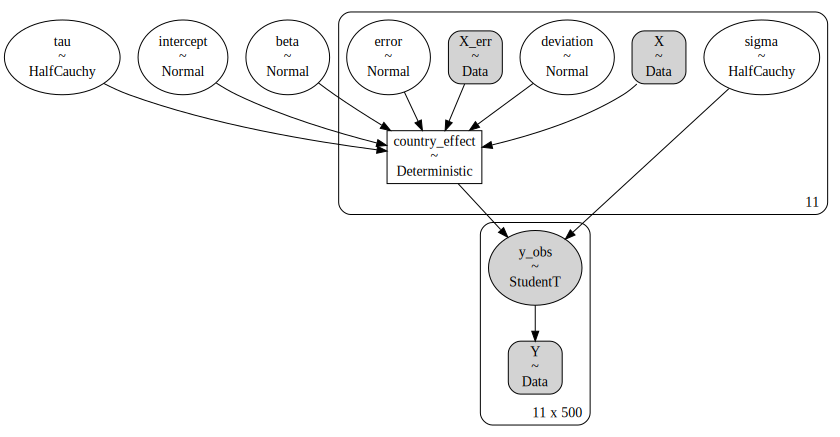

In [64]:
import arviz as az
pm.model_graph.model_to_graphviz(modelStringencyPreEURO2020)

## Main figure
Main figure containing one mobility correlation plot and the potential plot

In [26]:
from covid19_soccer.plot.utils import get_flag
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from covid19_soccer.plot.utils import k_formatter
from matplotlib.ticker import PercentFormatter
import string
colors = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']

def plot_linear_corr(ax, trace, colors):
    """ Simple correlation plot using a pymc3 trace
    """
    # Get datapoints
    Y = np.array(trace.constant_data["Y"])
    if Y.ndim > 1:
        Y = np.median(Y,axis=1)
    if "Y_err" in trace.constant_data:
        Y_err = np.array(trace.constant_data["Y_err"])
    else:
        Y_err = np.median(trace.posterior["sigma"].values,axis=(0,1))
    X = np.array(trace.constant_data["X"])
    X_err = np.array(trace.constant_data["X_err"])
    
    for i,(x,y,x_err,y_err) in enumerate(zip(X,Y,X_err,Y_err)):
        # Plot data with error
        lines = ax.hlines(
            y=y,
            xmin=x+x_err,
            xmax=x-x_err,
            lw=2,
            zorder=9+i,
            color=colors[i],
        )
        lines.set_capstyle("round")
        lines = ax.vlines(
            x=x,
            ymin=y+y_err,
            ymax=y-y_err,
            lw=2,
            zorder=9+i,
            color=colors[i],
        )
        lines.set_capstyle("round")

        ax.scatter(
            x=x,
            y=y,
            marker="o",
            s=10,
            c="white",
            zorder=10+i,
            edgecolor=colors[i],
        )

    # Plot fit from trace
    x_range = np.linspace(ax.get_xlim()[0],ax.get_xlim()[1],3000)

    beta = np.array(trace.posterior["beta"][:,:])
    beta = beta.reshape(beta.shape[0]*beta.shape[1])

    inter = np.array(trace.posterior["intercept"])
    inter = inter.reshape(inter.shape[0]*inter.shape[1])

    y = inter[np.newaxis,...]+x_range[:,np.newaxis]@beta[np.newaxis,...]

    ax.plot(x_range,y.mean(axis=1),color="tab:gray",lw=1)
    p = np.percentile(y,[2.5,97.5],axis=1)
    ax.fill_between(x_range,p[0],p[1],color="tab:gray",alpha=0.2,zorder=-4)
    
    ax.set_xlim(x_range[0], x_range[-1])
    
    return ax


from covid19_soccer.plot.other import HandlerPatchImage,PatchImage,MulticolorPatchHandler,MulticolorPatch
from matplotlib.patches import Patch, Rectangle
def legend(ax,colors,loc="center"):
    # Legend
    image_urls = []
    iso2 = []
    for i, dl in enumerate(dls):
        image_urls.append(get_flag(dl.countries_iso2[0].lower(),"/tmp/"))
        iso2.append(dl.countries_iso2[0].replace("GB-", ""))
        
        
        
    lines = []
    for i,color in enumerate(colors):
        lines.append(MulticolorPatch(colors=[color]))
    ax.legend(
        lines,
        iso2,
        loc=loc,
        handler_map={MulticolorPatch:MulticolorPatchHandler()},
    )

def add_p_val_R_squared(p_val, R_squared_dist, ax, smaller = True, padding=False):
    p_val = float(p_val)
    
    if p_val < 0.001:
        p_val_text = f"$P($slope {'<' if smaller else '>'} 0$) < {0.001}$"
    else:
        formatted_num = f"{p_val:.3f}" if p_val < 0.02 else f"{p_val:.2f}"
        if padding:
            ax.set_ylim(ax.get_ylim()[0],ax.get_ylim()[1]+(ax.get_ylim()[1]-ax.get_ylim()[0])/6)
        p_val_text = f"$P($slope {'<' if smaller else '>'} 0$) \simeq {formatted_num}$"
                            
    median, lower_CI, upper_CI = np.percentile(R_squared_dist, q = (50, 2.5, 97.5))
    R_squared_text = f"R$^2$ = {median:.2f} (CI: [{lower_CI:.2f}, {upper_CI:.2f}])"
                            
    ax.text(x=0.03, y = 1, s=f"{R_squared_text}\n{p_val_text}",
        horizontalalignment='left',
        verticalalignment='top',
        transform=ax.transAxes, fontsize=6.5)
    
def calc_R_squared(trace):
    """
    Calc R-squared distribution according to Gelman et al., Amer. Stat., 2019.
    """
    intercept = trace.posterior["intercept"].values[..., None]
    error = trace.posterior["error"].values * trace.constant_data["X_err"].values
    beta = trace.posterior["beta"].values[...,None]
    x_data = trace.constant_data["X"].values
    mu = intercept+(x_data+error)*beta
    explained_var = np.var(mu, ddof=1, axis=-1)
    res_var = trace.posterior["tau"]**2
    return explained_var / (res_var+explained_var)


    
def calc_R_squared(trace):
    """
    Calc R-squared distribution according to Gelman et al., Amer. Stat., 2019.
    """
    intercept = trace.posterior["intercept"].values[..., None]
    error = trace.posterior["error"].values * trace.constant_data["X_err"].values
    beta = trace.posterior["beta"].values[...,None]
    x_data = trace.constant_data["X"].values
    
    mu = intercept+(x_data+error)*beta
    explained_var = np.var(mu, ddof=1, axis=-1)
    res_var = trace.posterior["tau"]**2
    return explained_var / (res_var+explained_var)
    
def get_p(trace):
    return (trace.posterior["beta"] < 0).sum() / (trace.posterior["beta"].shape[0] * trace.posterior["beta"].shape[1])

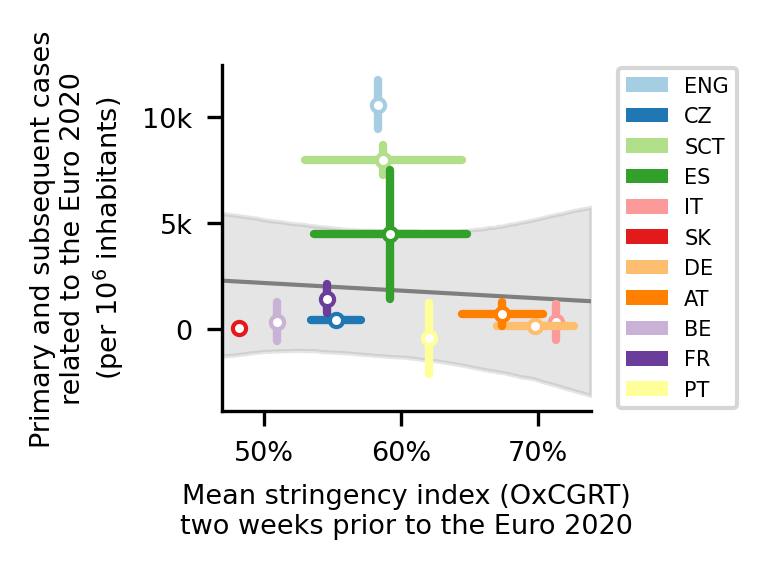

In [58]:
# Simple stringency plot
fig, axes = plt.subplots(1, 2, figsize=(2,1.5), gridspec_kw={"width_ratios":[1,0.05],"wspace":0.4})
plot_linear_corr(axes[0], traceStringencyPreEURO2020, colors)
axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)
axes[1].axis('off')

axes[0].set_ylabel("Primary and subsequent cases\nrelated to the Euro 2020\n(per $10^6$ inhabitants)")
axes[0].yaxis.set_major_formatter(k_formatter)

axes[0].set_xlabel("Mean stringency index (OxCGRT)\ntwo weeks prior to the Euro 2020")
axes[0].xaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0))
legend(axes[1],colors)
plt.show()
fig.savefig(f"../figures/SI/stringency_correlation.pdf", **save_kwargs)
fig.savefig(f"../figures/SI/stringency_correlation.png", **save_kwargs)
plt.close(fig=fig)

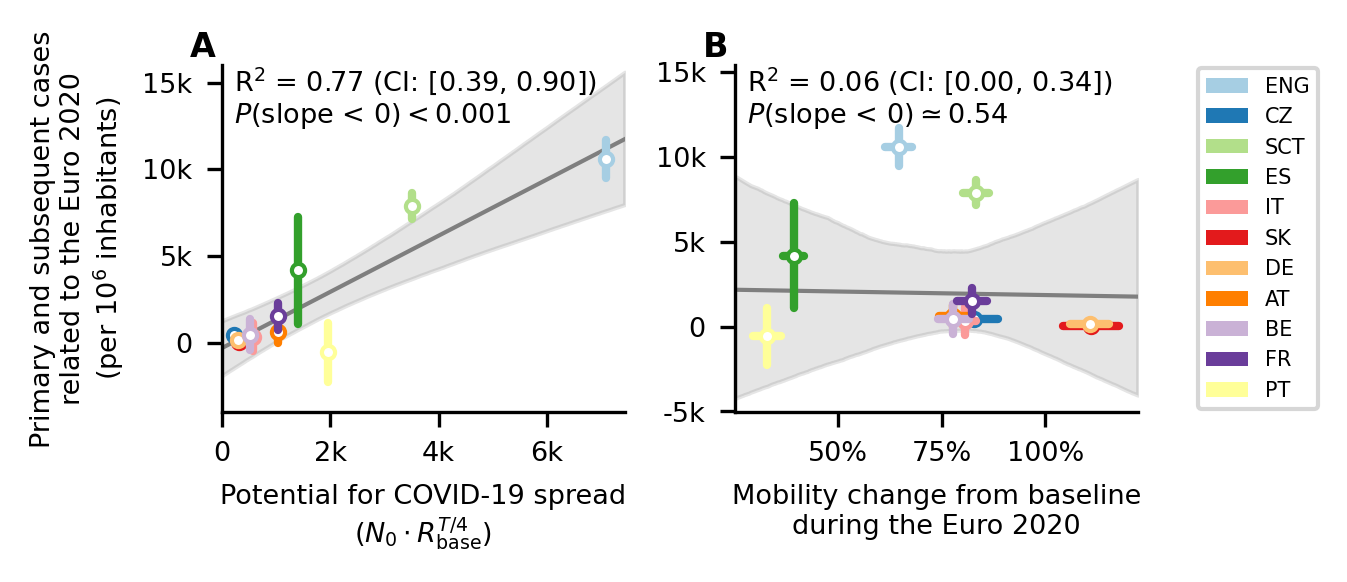

In [74]:
# Create figure
fig, axes = plt.subplots(1, 3, figsize=(4.5,1.5), gridspec_kw={"width_ratios":[1,1,0.05],"wspace":0.4})

# Model fits
plot_linear_corr(axes[1],traceMobilityParksInci,colors)
plot_linear_corr(axes[0],traceCombined1,colors)

# Calc p values
pMob = (traceMobilityParksInci.posterior["beta"] < 0).sum() / (traceMobilityParksInci.posterior["beta"].shape[0] * traceMobilityParksInci.posterior["beta"].shape[1])
pPot = (traceCombined1.posterior["beta"] < 0).sum() / (traceCombined1.posterior["beta"].shape[0] * traceCombined1.posterior["beta"].shape[1])

R_squared_mob = calc_R_squared(traceMobilityParksInci)
R_squared_pot = calc_R_squared(traceCombined1)


axes[1].set_xlabel("Mobility change from baseline\nduring the Euro 2020")
#axes[0].set_ylabel("Fraction of primary cases\nrelated to the Euro 2020")
axes[1].yaxis.set_major_formatter(k_formatter)
axes[1].xaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0))

axes[0].set_xlabel("Potential for COVID-19 spread\n($N_0\\cdot R^{T/4}_{{\\mathrm{base}}}}$)")
axes[0].set_ylabel("Primary and subsequent cases\nrelated to the Euro 2020\n(per $10^6$ inhabitants)")
axes[0].yaxis.set_major_formatter(k_formatter)
axes[0].xaxis.set_major_formatter(k_formatter)
axes[0].set_xlim(0)

#axes[0].set_ylim(-4000,16000)
axes[0].set_ylim(-4000,16000)

axes[2].get_xaxis().set_visible(False)
axes[2].get_yaxis().set_visible(False)
axes[2].axis('off')
legend(axes[2],colors)
add_p_val_R_squared(pMob, R_squared_mob, axes[1], smaller = True,padding=True)
add_p_val_R_squared(pPot, R_squared_pot, axes[0], smaller = True)

# Axis labels
alphabet_string = list(string.ascii_uppercase)
for i in range(2):
    letter = alphabet_string[i]
    axes[i].text(
        -0.015,
        1.1,
        letter,
        transform=axes[i].transAxes,
        fontsize=8,
        fontweight="bold",
        va="top",
        ha="right",
    )
    
plt.show()
fig.savefig(f"../figures/correlation.pdf", **save_kwargs)
fig.savefig(f"../figures/correlation.png", **save_kwargs)
plt.close(fig=fig)

In [100]:
traceMobilityParksInci.posterior["beta"].shape[0] * traceMobilityParksInci.posterior["beta"].shape[1]

8000

## SI figure

Mobility and other

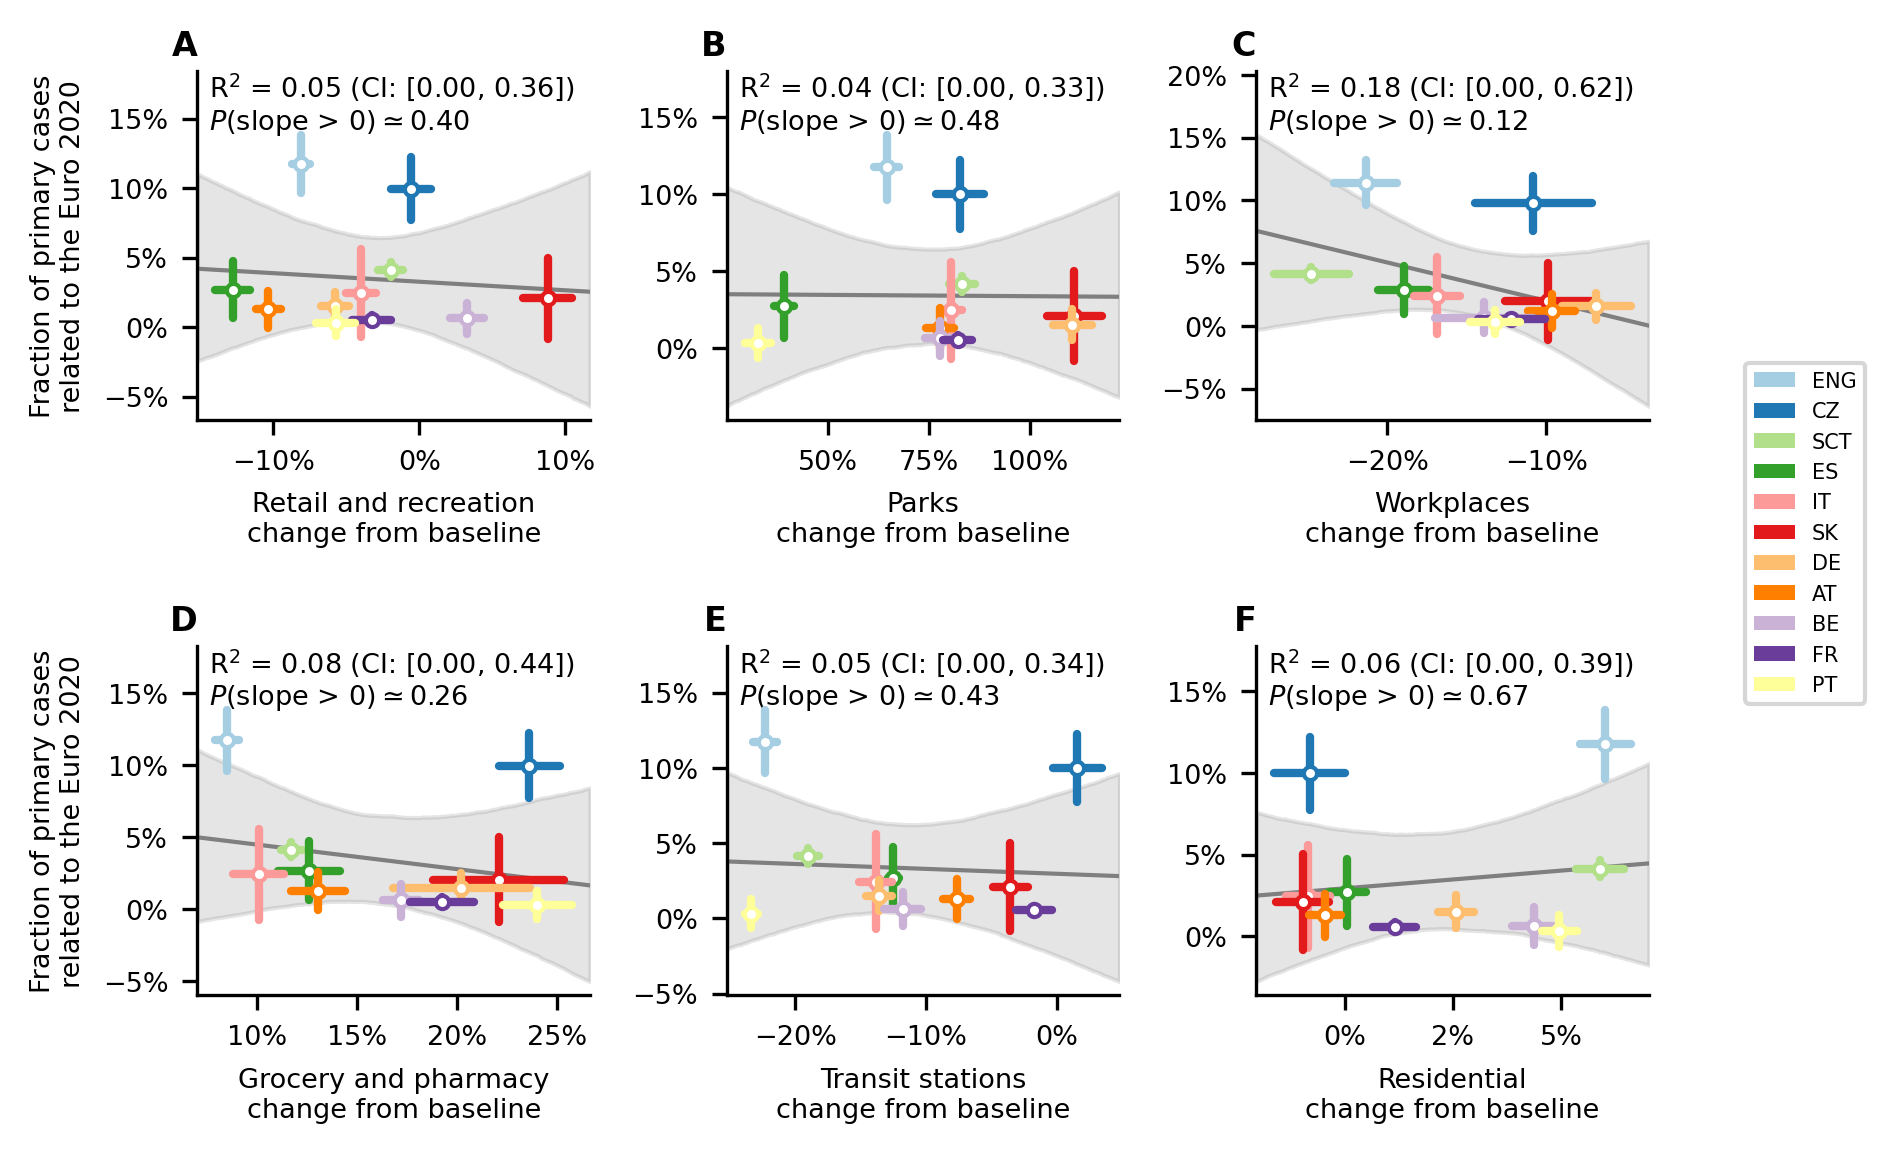

In [75]:
fig = plt.figure(figsize=(7, 4))
outer = mpl.gridspec.GridSpec(1,4, width_ratios=[1,1,1,0.1], wspace=0.45)
axes = []

for i in range(3):
    inner = mpl.gridspec.GridSpecFromSubplotSpec(
        2,1,
        subplot_spec=outer[i],
        wspace=0.1,
        hspace=0.65
    )
    for j in range(2):
        ax = fig.add_subplot(inner[j])
        axes.append(ax)

ax = fig.add_subplot(outer[3])
axes.append(ax)

plot_linear_corr(axes[0],traceMobilityRetail,colors)
plot_linear_corr(axes[1],traceMobilityGrocery,colors)
plot_linear_corr(axes[2],traceMobilityParks,colors)
plot_linear_corr(axes[3],traceMobilityTransit,colors)
plot_linear_corr(axes[4],traceMobilityWorkplace,colors)
plot_linear_corr(axes[5],traceMobilityResidential,colors)

# Calc p values

pRetail = get_p(traceMobilityRetail)
pGrocery = get_p(traceMobilityGrocery)
pParks = get_p(traceMobilityParks)
pTransit = get_p(traceMobilityTransit)
pWorkplace = get_p(traceMobilityWorkplace)
pResidential = get_p(traceMobilityResidential)

rRetail = calc_R_squared(traceMobilityRetail)
rGrocery = calc_R_squared(traceMobilityGrocery)
rParks = calc_R_squared(traceMobilityParks)
rTransit = calc_R_squared(traceMobilityTransit)
rWorkplace = calc_R_squared(traceMobilityWorkplace)
rResidential = calc_R_squared(traceMobilityResidential)

add_p_val_R_squared(np.round(1-pRetail,2), rRetail, axes[0], smaller = False, padding=True)
add_p_val_R_squared(np.round(1-pGrocery,2), rGrocery, axes[1], smaller = False, padding=True)
add_p_val_R_squared(np.round(1-pParks,2), rParks, axes[2], smaller = False, padding=True)
add_p_val_R_squared(np.round(1-pTransit,2), rTransit, axes[3], smaller = False, padding=True)
add_p_val_R_squared(np.round(1-pWorkplace,2), rWorkplace, axes[4], smaller = False, padding=True)
add_p_val_R_squared(np.round(1-pResidential,2), rResidential, axes[5], smaller = False, padding=True)

for i in range(6):
    axes[i].yaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0))
    axes[i].xaxis.set_major_formatter(mpl.ticker.PercentFormatter(decimals=0))

axes[0].set_ylabel("Fraction of primary cases\nrelated to the Euro 2020")
axes[1].set_ylabel("Fraction of primary cases\nrelated to the Euro 2020")

['retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline']

axes[0].set_xlabel("Retail and recreation\nchange from baseline")
axes[1].set_xlabel("Grocery and pharmacy\nchange from baseline")
axes[2].set_xlabel("Parks\nchange from baseline")
axes[3].set_xlabel("Transit stations\nchange from baseline")
axes[4].set_xlabel("Workplaces\nchange from baseline")
axes[5].set_xlabel("Residential\nchange from baseline")
# Legend
axes[6].get_xaxis().set_visible(False)
axes[6].get_yaxis().set_visible(False)
axes[6].axis('off')
legend(axes[6],colors)

# Axis labels
alphabet_string = list(string.ascii_uppercase)
for s,i in enumerate([0,2,4,1,3,5]):
    letter = alphabet_string[s]
    axes[i].text(
        0,
        1.12,
        letter,
        transform=axes[i].transAxes,
        fontsize=8,
        fontweight="bold",
        va="top",
        ha="right",
    )
#plt.tight_layout()

fig.align_ylabels([axes[0],axes[1]])

plt.show()
fig.savefig(f"../figures/SI/correlations_mobility.pdf", **save_kwargs)
fig.savefig(f"../figures/SI/correlations_mobility.png", **save_kwargs)
plt.close(fig=fig)


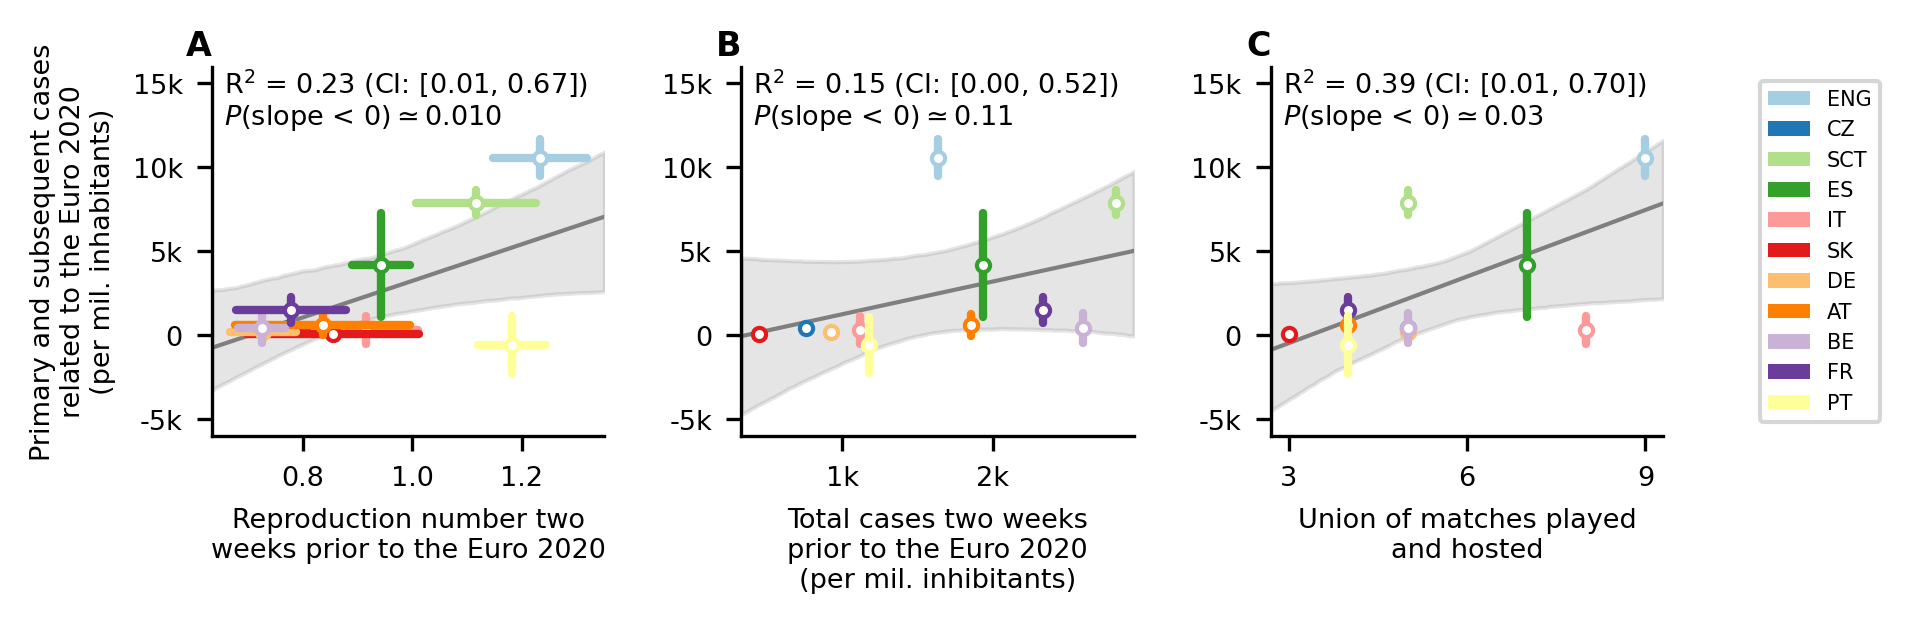

In [76]:
fig = plt.figure(figsize=(7, 1.6))
outer = mpl.gridspec.GridSpec(1,4, width_ratios=[1,1,1,0.1], wspace=0.45)
axes = []

for i in range(3):
    inner = mpl.gridspec.GridSpecFromSubplotSpec(
        1,1,
        subplot_spec=outer[i],
        wspace=0.1,
        hspace=0.65
    )
    for j in range(1):
        ax = fig.add_subplot(inner[j])
        axes.append(ax)

ax = fig.add_subplot(outer[3])
axes.append(ax)

plot_linear_corr(axes[0],traceReproPreEURO2020,colors)
plot_linear_corr(axes[1],traceIncidencePreEURO2020,colors)
plot_linear_corr(axes[2],traceNGamesInci,colors)

# Calc p values

pRepro = get_p(traceReproPreEURO2020)
pInci = get_p(traceIncidencePreEURO2020)
pNgames = get_p(traceNGamesInci)

rRepro = calc_R_squared(traceReproPreEURO2020)
rInci = calc_R_squared(traceIncidencePreEURO2020)
rNgames = calc_R_squared(traceNGamesInci)

add_p_val_R_squared(np.round(pRepro,2), rRepro, axes[0], smaller = True, padding=True)
add_p_val_R_squared(np.round(pInci,2), rInci, axes[1], smaller = True, padding=True)
add_p_val_R_squared(np.round(pNgames,2),rNgames, axes[2], smaller = True, padding=True)

for i in range(3):
    axes[i].yaxis.set_major_formatter(k_formatter)
    axes[i].set_ylim(-6000,16000)
    
axes[1].xaxis.set_major_formatter(k_formatter)
axes[0].set_ylabel("Primary and subsequent cases\nrelated to the Euro 2020\n(per mil. inhabitants)")

axes[0].set_xlabel("Reproduction number two\nweeks prior to the Euro 2020")
axes[1].set_xlabel("Total cases two weeks\nprior to the Euro 2020\n(per mil. inhibitants)")
axes[2].set_xlabel("Union of matches played\nand hosted")

axes[2].set_xticks([3,6,9])

# Legend
axes[3].get_xaxis().set_visible(False)
axes[3].get_yaxis().set_visible(False)
axes[3].axis('off')
legend(axes[3],colors)

# Axis labels
alphabet_string = list(string.ascii_uppercase)
for s,i in enumerate([0,1,2]):
    letter = alphabet_string[s]
    axes[i].text(
        0,
        1.1,
        letter,
        transform=axes[i].transAxes,
        fontsize=8,
        fontweight="bold",
        va="top",
        ha="right",
    )
#plt.tight_layout()

fig.align_ylabels([axes[0],axes[1]])

plt.show()
fig.savefig(f"../figures/SI/correlations_other.pdf", **save_kwargs)
fig.savefig(f"../figures/SI/correlations_other.png", **save_kwargs)
plt.close(fig=fig)


In [77]:
%load_ext watermark
%watermark -n -u -v -iv -w

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: Fri Aug 12 2022

Python implementation: CPython
Python version       : 3.8.10
IPython version      : 7.24.1

arviz            : 0.11.4
pymc3            : 3.11.2
matplotlib       : 3.5.1
covid19_inference: 0.3.6
pandas           : 1.2.4
numpy            : 1.20.3
sys              : 3.8.10 | packaged by conda-forge | (default, May 11 2021, 07:01:05) 
[GCC 9.3.0]

Watermark: 2.3.1

